## <center>Make imports

In [1]:
import time
import scipy.io
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.autograd import Variable
from torch.utils.data import TensorDataset, random_split
%matplotlib inline

In [2]:
mnist = scipy.io.loadmat('mnist_all.mat') #loading data

## <center>Parsing function

In [12]:
def parse_mnist(filename = 'mnist_all.mat', n_cut_train = 1000, n_cut_test = 500, normalize = True):
    file = scipy.io.loadmat(filename)
    
    train_data = np.zeros((10, n_cut_train, 784))
    train_label = np.zeros((10, n_cut_train))
    test_data = np.zeros((10, n_cut_test, 784))
    test_label = np.zeros((10, n_cut_test))
    
    for i in range(10):
        name_train = 'train' + str(i)
        name_test = 'test' + str(i)
        train_data[i] = file[name_train][:n_cut_train]
        train_label[i].fill(i)   
        test_data[i] = file[name_test][:n_cut_test]
        test_label[i].fill(i)

    train_data = train_data.reshape(-1, 784)
    train_label = train_label.reshape(-1)
    test_data = test_data.reshape(-1, 784)
    test_label = test_label.reshape(-1)

    if normalize:
        train_data = train_data/255.0
        test_data = test_data/255.0

    train_data = TensorDataset(torch.from_numpy(np.float32(train_data)), torch.from_numpy(np.int64(train_label)))
    test_data = TensorDataset(torch.from_numpy(np.float32(test_data)), torch.from_numpy(np.int64(test_label)))
    
    return train_data, test_data

In [13]:
train_data, test_data = parse_mnist(normalize=True)

## <center> Create the linear model

In [14]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256,10)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
simplenet = SimpleNet()

## <center> Set parameters

In [16]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)
batch_size = 64
loss_function = nn.CrossEntropyLoss()

## <center>Split data for training and validation data and creating loaders

In [17]:
train1, val1 = random_split(train_data, (8000, 2000))

train_data_loader = DataLoader(train1, batch_size = batch_size, shuffle=True)
val_data_loader = DataLoader(val1, batch_size = batch_size)

## <center>Train and evaluate the model

In [19]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20):
    acc1 = []
    loss1 = []
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
       
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=0), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        
        acc1.append(num_correct/num_examples)
        loss1.append(training_loss)
        
        print('Epoch: {:2d}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
    return acc1, loss1

In [20]:
acc, loss = train(simplenet, optimizer, loss_function, train_data_loader, val_data_loader, epochs=20)

Epoch:  0, Training Loss: 0.64, Validation Loss: 0.36, accuracy = 0.81
Epoch:  1, Training Loss: 0.28, Validation Loss: 0.31, accuracy = 0.83
Epoch:  2, Training Loss: 0.22, Validation Loss: 0.28, accuracy = 0.85
Epoch:  3, Training Loss: 0.18, Validation Loss: 0.27, accuracy = 0.86
Epoch:  4, Training Loss: 0.14, Validation Loss: 0.28, accuracy = 0.85
Epoch:  5, Training Loss: 0.12, Validation Loss: 0.29, accuracy = 0.85
Epoch:  6, Training Loss: 0.10, Validation Loss: 0.24, accuracy = 0.87
Epoch:  7, Training Loss: 0.09, Validation Loss: 0.26, accuracy = 0.86
Epoch:  8, Training Loss: 0.08, Validation Loss: 0.26, accuracy = 0.86
Epoch:  9, Training Loss: 0.06, Validation Loss: 0.26, accuracy = 0.84
Epoch: 10, Training Loss: 0.05, Validation Loss: 0.26, accuracy = 0.86
Epoch: 11, Training Loss: 0.04, Validation Loss: 0.29, accuracy = 0.87
Epoch: 12, Training Loss: 0.04, Validation Loss: 0.27, accuracy = 0.86
Epoch: 13, Training Loss: 0.03, Validation Loss: 0.28, accuracy = 0.86
Epoch:

## <center>Compare predicted labels of 9 random images with their true labels

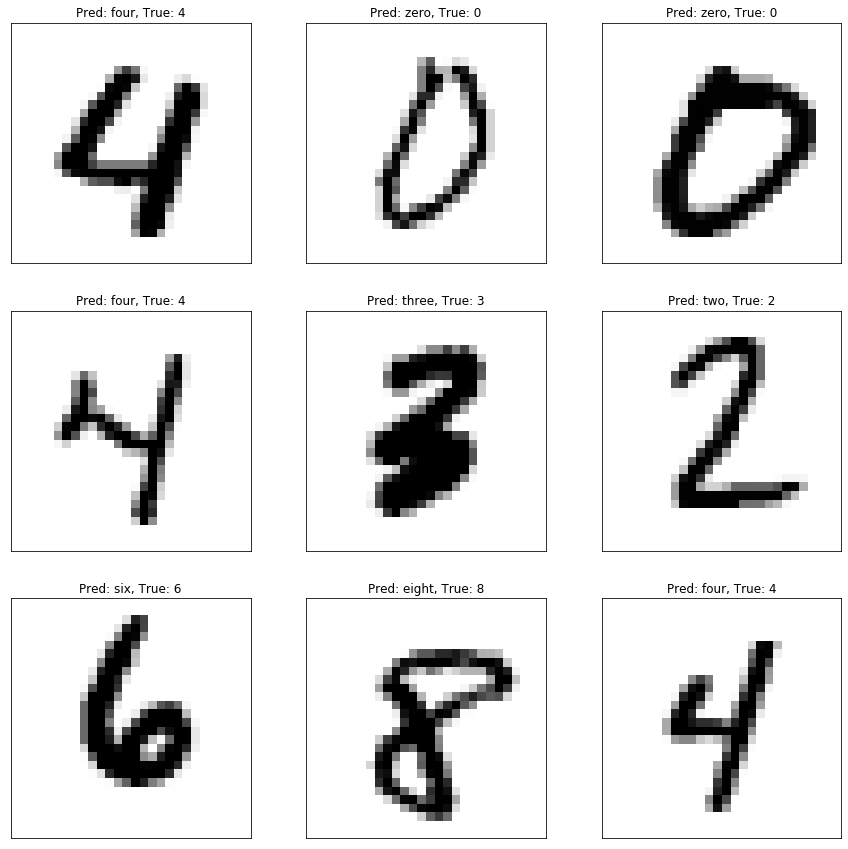

In [21]:
labels = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight',  'nine']
fig, ax = plt.subplots(3,3, figsize=(15,15))
for i in range(3):
    for j in range(3):
        element, labs = test_data[random.randint(0,5000)]
        tensor_image = element.view(28,28)
        ax[i][j].imshow(tensor_image, cmap = plt.cm.gray_r)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

        prediction = F.softmax(simplenet(element.unsqueeze(0)), dim=1)
        prediction_l = prediction.argmax()

        ax[i][j].title.set_text('Pred: {}, True: {}'.format(labels[prediction_l],labs))
plt.show()   

### <center>Accuracy check at the test data

In [22]:
test_loader = DataLoader(test_data, batch_size=batch_size) #making the test data a loader

#counting errors
err = 0
for batch in test_loader:
    im, lb = batch
    prediction = F.softmax(simplenet(im), dim=1)
    for k, res in enumerate(prediction):
        if res.argmax().item() != lb[k].item():
            err += 1
print('Accuracy of this simple net for test set is: {:.2f}%'.format((len(test_loader.dataset)- err)*100/len(test_loader.dataset)))

Accuracy of this simple net for test set is: 92.92%


### <center>Validation Accuracy and Training Loss graphs

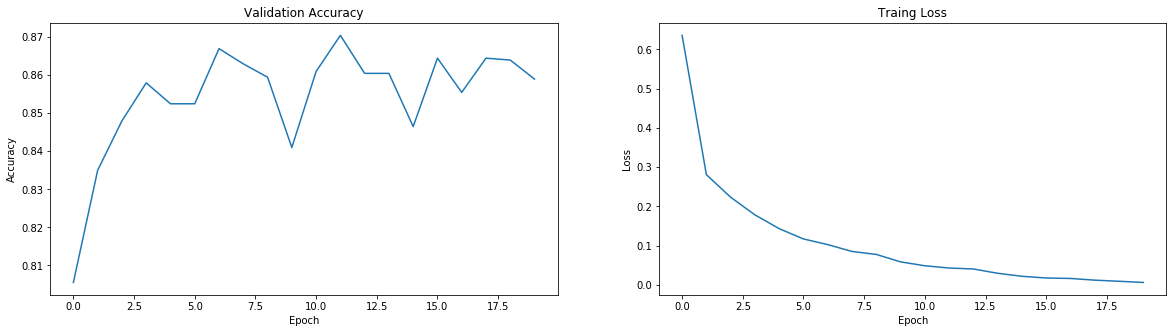

In [23]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].title.set_text('Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].plot(list(range(len(acc))), acc)

ax[1].title.set_text('Traing Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].plot(list(range(len(loss))), loss)
plt.show()